# Multi-Task Network - Simultaneous Object Detection and Semantic Segmentation

In this notebook, I'll show a network that can perform two tasks at the same time: object detection and semantic segmentation. While combining these tasks in a single model might not sound particularly useful, it was a fun and challenging project that helped me learn a lot.

I built everything from scratch using just NumPy and TensorFlow, and I trained the model on a proprietary dataset from my company. This dataset was designed for a robot vision system in a warehouse, with three main classes: persons, forklifts, and rails.

To keep the model lightweight and suitable for real-time applications on mobile devices, I experimented with two backbone networks: MobileNetV2 and ShuffleNetV2. Unfortunately, due to time constraints, I was only able to train MobileNetV2 and didn't get to try out the ShuffleNetV2 implementation I created (I hope it works).

For object detection, I followed the [Single Shot MultiBox Detector (SSD)](https://arxiv.org/pdf/1512.02325) framework, based on the original paper but using depthwise separable convolutions to keep the network as lightweight as possible. This approach is sometimes referred to as SSDLite. For semantic segmentation, I followed the [DeepLabV3+](https://arxiv.org/pdf/1802.02611) implementation details as described in the original paper.

## Dependecies and Parameters

Let's quickly import dependecies and define some useful parameters for this notebook.

In [1]:
# dependecies
import tensorflow as tf
tf.keras.saving.get_custom_objects().clear()
tf.random.set_seed(1993)
import random
random.seed(1993)
import json
import csv
import numpy as np
from matplotlib import pyplot as plt, patches
from PIL import Image
import ssdseglib

# models path
MODELS_PATH = 'models'
MODEL_NAME = 'mobilenetv2-deeplabv3plus-ssdlite'
# MODEL_NAME = 'shufflenetv2-1x-deeplabv3plus_3_6_12-ssdlite'

# data options
INPUT_IMAGE_SHAPE = (480, 640, 3)
LABELS_CODES = [0, 1, 2, 3]
LABEL_CODE_BACKGROUND = 0
NUMBER_OF_CLASSES = len(LABELS_CODES)

# object detection options
STANDARD_DEVIATIONS_CENTROIDS_OFFSETS = (0.1, 0.1, 0.2, 0.2)

# labels conversions
LABEL_CODE_TO_DESC = {
    1: 'monorail',
    2: 'person',
    3: 'forklift'
}
LABEL_CODE_TO_COLOR = {
    1: 'red',
    2: 'green',
    3: 'blue'
}

# tensorflow options
BATCH_SIZE = 16

## Load Metadata

Let's load metadata containing files paths to images, boxes coordinates and segmentation masks

In [2]:
# train metadata
data = []

# train main metadata
with open('data/train.json', 'r') as f:
    data.extend(json.load(f))

# train additional metadata - persons
with open('data/train-additional-persons.json', 'r') as f:
    persons = json.load(f)
    persons = random.sample(persons, int(len(persons)*0.8))
    data.extend(persons)

# train additional metadata - forklifts
with open('data/train-additional-forklifts.json', 'r') as f:
    data.extend(json.load(f))

# the training set it's small and the validation set even smaller..
# it's so small that probably any metrics on it won't be particularly reliable 
# at this point maybe it's just better to use the validation set as additional training data
with open('data/eval-persons-forklifts.json', 'r') as f:
    data.extend(json.load(f))

# unpack train metadata into separate lists
path_files_images_train, path_files_masks_train, path_files_labels_boxes_train = map(list, zip(*data))

# test
with open('data/test.json', 'r') as f:
    path_files_images_test, path_files_masks_test, path_files_labels_boxes_test = map(list, zip(*json.load(f)))

## Define Default Boxes and Data Reader Encoder

Here we define some default grids and boxes as described by the SSD paper. See previous notebooks for more details.

We also initialize a custom class that will help reading and encode data.

In [3]:
# create default bounding boxes
boxes_default = ssdseglib.boxes.DefaultBoundingBoxes(
    feature_maps_shapes=((30, 40), (15, 20), (8, 10), (4, 5)),
    centers_padding_from_borders_percentage=(0.025, 0.05, 0.075, 0.1),
    boxes_scales=(0.15, 0.95),
    additional_square_box=True,
)

# rescale default bounding boxes to input image shape
boxes_default.rescale_boxes_coordinates(image_shape=INPUT_IMAGE_SHAPE[:2])

# create a data reader encoder
data_reader_encoder = ssdseglib.datacoder.DataEncoderDecoder(
    num_classes=NUMBER_OF_CLASSES,
    image_shape=INPUT_IMAGE_SHAPE[:2],
    xmin_boxes_default=boxes_default.get_boxes_coordinates_xmin(coordinates_style='ssd'),
    ymin_boxes_default=boxes_default.get_boxes_coordinates_ymin(coordinates_style='ssd'),
    xmax_boxes_default=boxes_default.get_boxes_coordinates_xmax(coordinates_style='ssd'),
    ymax_boxes_default=boxes_default.get_boxes_coordinates_ymax(coordinates_style='ssd'),
    iou_threshold=0.525,
    standard_deviations_centroids_offsets=STANDARD_DEVIATIONS_CENTROIDS_OFFSETS,
    augmentation_horizontal_flip=True
)

## Tensorflow Data Pipelines

Tensorflow data pipelines are easy to use and provide a simple and effective way to load and transform data in batches before feeding them in a network. In this case each file it's loaded and encoded, then a data augmentation function it's applied to images in batches. Basic transformations such as horizontal flips, vertical flips, contrast, saturation and hue changes are randomly applied.

In [4]:
# training
ds_train = (
    tf.data.Dataset.from_tensor_slices((path_files_images_train, path_files_masks_train, path_files_labels_boxes_train))
    .shuffle(buffer_size=len(path_files_images_train))
    .map(data_reader_encoder.read_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(ssdseglib.datacoder.augmentation_rgb_channels, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# eval
ds_eval = (
    tf.data.Dataset.from_tensor_slices((path_files_images_test, path_files_masks_test, path_files_labels_boxes_test))
    .shuffle(buffer_size=len(path_files_images_test))
    .map(data_reader_encoder.read_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(ssdseglib.datacoder.augmentation_rgb_channels, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# test
ds_test = (
    tf.data.Dataset.from_tensor_slices(path_files_images_test)
    .map(ssdseglib.datacoder.read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Custom Losses and Metrics

Let's initialize some custom losses and metrics using some classes weights (there is a certain degree of class imbalance in this dataset).

In [5]:
# weighted loss for semantic segmentation
cross_entropy_loss = ssdseglib.losses.cross_entropy(classes_weights=(0.05, 0.575, 0.135, 0.24))

# weighted metrics for semantic segmentation
jaccard_iou_segmentation_masks_metric = ssdseglib.metrics.jaccard_iou_segmentation_masks(classes_weights=(0.05, 0.575, 0.135, 0.24))

# weighted metrics for boxes classification
categorical_accuracy_metric = ssdseglib.metrics.categorical_accuracy(classes_weights=(0., 1/3, 1/3, 1/3))

# metrics for boxes regression
jaccard_iou_bounding_boxes_metric = ssdseglib.metrics.jaccard_iou_bounding_boxes(
    center_x_boxes_default=data_reader_encoder.center_x_boxes_default,
    center_y_boxes_default=data_reader_encoder.center_y_boxes_default,
    width_boxes_default=data_reader_encoder.width_boxes_default,
    height_boxes_default=data_reader_encoder.height_boxes_default,
    standard_deviations_centroids_offsets=STANDARD_DEVIATIONS_CENTROIDS_OFFSETS
)

## Model Architecture

Here we initialize a MobileNetV2 backbone, with an object detection head and a segmentation head.

In [6]:
# initialize model builder mobilenetv2
model_builder = ssdseglib.models.MobileNetV2SsdSegBuilder(
    input_image_shape=INPUT_IMAGE_SHAPE,
    number_of_boxes_per_point=[
        len(aspect_ratios) + (1 if boxes_default.additional_square_box else 0)
        for aspect_ratios in boxes_default.feature_maps_aspect_ratios
    ],
    number_of_classes=NUMBER_OF_CLASSES,
    center_x_boxes_default=boxes_default.get_boxes_coordinates_center_x(coordinates_style='ssd'),
    center_y_boxes_default=boxes_default.get_boxes_coordinates_center_y(coordinates_style='ssd'),
    width_boxes_default=boxes_default.get_boxes_coordinates_width(coordinates_style='ssd'),
    height_boxes_default=boxes_default.get_boxes_coordinates_height(coordinates_style='ssd'),
    standard_deviations_centroids_offsets=STANDARD_DEVIATIONS_CENTROIDS_OFFSETS
)

# # initialize model builder shufflenetv2
# model_builder = ssdseglib.models.ShuffleNetV2SsdSegBuilder(
#     input_image_shape=INPUT_IMAGE_SHAPE,
#     model_size='1.5x',
#     use_additional_depthwise_convolution=True,
#     use_residual_connections=True,
#     number_of_boxes_per_point=[
#         len(aspect_ratios) + (1 if boxes_default.additional_square_box else 0)
#         for aspect_ratios in boxes_default.feature_maps_aspect_ratios
#     ],
#     number_of_classes=NUMBER_OF_CLASSES,
#     center_x_boxes_default=boxes_default.get_boxes_coordinates_center_x(coordinates_style='ssd'),
#     center_y_boxes_default=boxes_default.get_boxes_coordinates_center_y(coordinates_style='ssd'),
#     width_boxes_default=boxes_default.get_boxes_coordinates_width(coordinates_style='ssd'),
#     height_boxes_default=boxes_default.get_boxes_coordinates_height(coordinates_style='ssd'),
#     standard_deviations_centroids_offsets=STANDARD_DEVIATIONS_CENTROIDS_OFFSETS
# )

# get model for training
model = model_builder.get_model_for_training(
    segmentation_architecture='deeplabv3plus',
    object_detection_architecture='ssdlite',
    segmentation_dilation_rates=(3, 6, 12)    
)

# print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 backbone-input (InputLayer  [(None, 480, 640, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 backbone-input-rescaling (  (None, 480, 640, 3)          0         ['backbone-input[0][0]']      
 Rescaling)                                                                                       
                                                                                                  
 backbone-block0-expand-con  (None, 240, 320, 32)         864       ['backbone-input-rescaling[0][
 v (Conv2D)                                                         0]']                    

## Model Compilation

Let's compile the model defining an optimizer, losses, metrics and weights.

In [7]:
# each ouput has its own loss and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'output-mask': cross_entropy_loss,
        'output-labels': ssdseglib.losses.confidence_loss,
        'output-boxes': ssdseglib.losses.localization_loss
    },
    loss_weights={
        'output-mask': 1.0,
        'output-labels': 1.0,
        'output-boxes': 1.0
    },
    metrics={
        'output-mask': jaccard_iou_segmentation_masks_metric,
        'output-labels': categorical_accuracy_metric,
        'output-boxes': jaccard_iou_bounding_boxes_metric,
    }
)

## Model Training

We train and save the model.

In [9]:
# fit the model
history = model.fit(
    ds_train,
    epochs=105,
    validation_data=ds_eval,
    verbose=0
)

In [10]:
# save model
model.save(f'{MODELS_PATH}/{MODEL_NAME}-105-epoch.keras')

## Model Inference

We load the trained model.

In [12]:
# load trained model
model_trained = tf.keras.models.load_model(f'{MODELS_PATH}/{MODEL_NAME}-105-epoch.keras', compile=False)

### NMS Hypertuning (Non-Maximum-Suppression)

Our model has two heads: one for object detection and one for semantic segmentation.

In previous notebooks, we've explored how a network using SSD (Single Shot Detector) bases its predictions on a set of default boxes. Specifically, it predicts how to move and scale these default boxes to properly contain an object, along with the probability of each default box containing a particular object. To obtain proper bounding boxes, we need to decode and convert these offsets into actual coordinates on the image.

But... there's a problem. A network using SSD have a huge number of default boxes, and guess what? It predicts offsets and probabilities for all of these boxes, even when there are no objects in the image at all.

So, how do we get just one bounding box around our object of interest?

Well, we can start by looking at the probabilities... but what if we have multiple boxes overlapping themselves each with an high probability of containing the same object?

Yeah... just relying on probabilities isn't enough because multiple boxes often predict the same object, resulting in overlapping bounding boxes. This is where Non-Maximum Suppression (NMS) comes into play. NMS helps us filter out these overlapping boxes by selecting the box with the highest probability and suppressing the rest that overlap with it beyond a certain threshold. I'm not gonna explain NMS in details, it's out of the scope of this notebook.. just think about it as a way of suppress overlapping boxes and keep only a single box with better fit and confidence.

**NMS Hypertuning** 

To make NMS work well, we need to tune a key setting: the IoU (Intersection over Union) threshold. This setting controls how much overlap between boxes we’re okay with before we start discarding the lower-scoring ones.

- Too Low IoU Threshold: If the threshold is too low, we might throw away good boxes and miss actual objects.

- Too High IoU Threshold: If it’s too high, we might keep too many boxes, leading to duplicate detections of the same object.

The trick is finding the sweet spot where we keep the best boxes without missing objects or doubling up on detections. This tuning can make a big difference in how accurate our model is.

In the code below I tried a grid of values for the hyperparameters in order to select the ones achieving better results.

In [ ]:
# thresholds grid
boxes_iou_thresholds = (0.025, 0.05, 0.075)
labels_probability_thresholds = (0.7, 0.725, 0.75)

# set the iou thresholds to use for evaluate average precision in object detection
map_iou_thresholds_object_detection = [0.5, 0.6, 0.75]

# calculate the maximum label length
length_longest_label = max(len(label) for label in LABEL_CODE_TO_DESC.values())

# try every thresholds combination and find the best one
for boxes_iou_threshold in boxes_iou_thresholds:
    for labels_probability_threshold in labels_probability_thresholds:

        print('-------------------------------------------------------------------------------------------------------')
        print(f'> boxes iou threshold: {boxes_iou_threshold}, labels probability threshold: {labels_probability_threshold}')
        print('-------------------------------------------------------------------------------------------------------')

        # initialize the inference model
        model_inference = model_builder.get_model_for_inference(
            model_trained=model_trained,
            max_number_of_boxes_per_class=4,
            max_number_of_boxes_per_sample=10,
            boxes_iou_threshold=boxes_iou_threshold,
            labels_probability_threshold=labels_probability_threshold,
            suppress_background_boxes=False,
            use_segmentation_suppression=True
        )

        # get model predictions
        _, detection_pred_batch = model_inference.predict(ds_test)

        # split and format predictions as required by the evaluators
        labels_pred_batch = detection_pred_batch[:, :, 0].astype(np.int32)
        confidences_pred_batch = detection_pred_batch[:, :, 1].astype(np.float32)
        boxes_pred_batch = detection_pred_batch[:, :, 2:].astype(np.float32)

        # for each iou threshold calculate AP and mAP
        for map_iou_threshold in map_iou_thresholds_object_detection:
            average_precision_per_class = ssdseglib.evaluators.average_precision_object_detection(
                labels_pred_batch=labels_pred_batch,
                confidences_pred_batch=confidences_pred_batch,
                boxes_pred_batch=boxes_pred_batch,
                iou_threshold=map_iou_threshold,
                path_files_labels_boxes=path_files_labels_boxes_test,
                labels_codes=LABELS_CODES,
                label_code_background=LABEL_CODE_BACKGROUND
            )

            # iou threshold formatted for printing
            iou_threshold = format(map_iou_threshold, '.2f').lstrip('0')

            # print
            print('\n****************')
            print(f'***  AP@{iou_threshold}  ***')
            print('****************')
            for label, average_precision in average_precision_per_class.items():
                print(f'> {LABEL_CODE_TO_DESC[label]:>{length_longest_label}}: {average_precision:2.2f}')
            print('----------------')
            print(f'> {f"mAP@{iou_threshold}":>{length_longest_label}}: {sum(average_precision_per_class.values()) / len(average_precision_per_class):.2f}')            

### Load the Model for Inference

Finally we get the model for inference from the trained model, using the optimal parameters for NMS.

In [34]:
# transfer weights
model_inference = model_builder.get_model_for_inference(
    model_trained=model_trained,
    max_number_of_boxes_per_class=4,
    max_number_of_boxes_per_sample=10,
    boxes_iou_threshold=0.025,
    labels_probability_threshold=0.725,
    suppress_background_boxes=False,
    use_segmentation_suppression=True
)

## Quick Evaluation

In [35]:
# get predictions for the whole test set
segmentation_pred_batch, detection_pred_batch = model_inference.predict(ds_test)

# split and format predictions as required by the evaluators
segmentation_pred_batch = segmentation_pred_batch.astype(np.float32)
labels_pred_batch = detection_pred_batch[:, :, 0].astype(np.int32)
confidences_pred_batch = detection_pred_batch[:, :, 1].astype(np.float32)
boxes_pred_batch = detection_pred_batch[:, :, 2:].astype(np.float32)

31/31 [==============================] - 56s 2s/step


### Jaccard IoU

In [36]:
# evaluate iou for each class
iou_per_class = ssdseglib.evaluators.jaccard_iou_semantic_segmentation(
    masks_pred_batch=segmentation_pred_batch,
    path_files_masks=path_files_masks_test,
    labels_codes=LABELS_CODES,
    label_code_background=LABEL_CODE_BACKGROUND
)

# calculate the maximum label length
length_longest_label = max(len(label) for label in LABEL_CODE_TO_DESC.values())

# print
print('\n****************')
print(f'***   IoU    ***')
print('****************')
for label, iou in iou_per_class.items():
    print(f'> {LABEL_CODE_TO_DESC[label]:>{length_longest_label}}: {iou:2.2f}')
print('----------------')
print(f'> {"mIoU@":>{length_longest_label}}: {sum(iou_per_class.values()) / len(iou_per_class):.2f}') 


****************
***   IoU    ***
****************
> monorail: 0.50
>   person: 0.18
> forklift: 0.30
----------------
>    mIoU@: 0.33


### Average Precision (AP and mAP)

In [37]:
# set the iou thresholds to use for evaluate average precision in object detection
iou_thresholds_object_detection = [0.5, 0.6, 0.7]

# calculate the maximum label length
length_longest_label = max(len(label) for label in LABEL_CODE_TO_DESC.values())

# for each iou threshold calculate AP and mAP
for iou_threshold in iou_thresholds_object_detection:
    average_precision_per_class = ssdseglib.evaluators.average_precision_object_detection(
        labels_pred_batch=labels_pred_batch,
        confidences_pred_batch=confidences_pred_batch,
        boxes_pred_batch=boxes_pred_batch,
        iou_threshold=iou_threshold,
        path_files_labels_boxes=path_files_labels_boxes_test,
        labels_codes=LABELS_CODES,
        label_code_background=LABEL_CODE_BACKGROUND
    )

    # iou threshold formatted for printing
    iou_threshold = format(iou_threshold, '.2f').lstrip('0')

    # print
    print('\n****************')
    print(f'***  AP@{iou_threshold}  ***')
    print('****************')
    for label, average_precision in average_precision_per_class.items():
        print(f'> {LABEL_CODE_TO_DESC[label]:>{length_longest_label}}: {average_precision:2.2f}')
    print('----------------')
    print(f'> {f"mAP@{iou_threshold}":>{length_longest_label}}: {sum(average_precision_per_class.values()) / len(average_precision_per_class):.2f}')    


****************
***  AP@.50  ***
****************
> monorail: 0.49
>   person: 0.56
> forklift: 0.54
----------------
>  mAP@.50: 0.53

****************
***  AP@.60  ***
****************
> monorail: 0.37
>   person: 0.51
> forklift: 0.51
----------------
>  mAP@.60: 0.46

****************
***  AP@.70  ***
****************
> monorail: 0.23
>   person: 0.31
> forklift: 0.44
----------------
>  mAP@.70: 0.33


## Predictions

Let's plot some sample predictions in order to visualize if the model works!

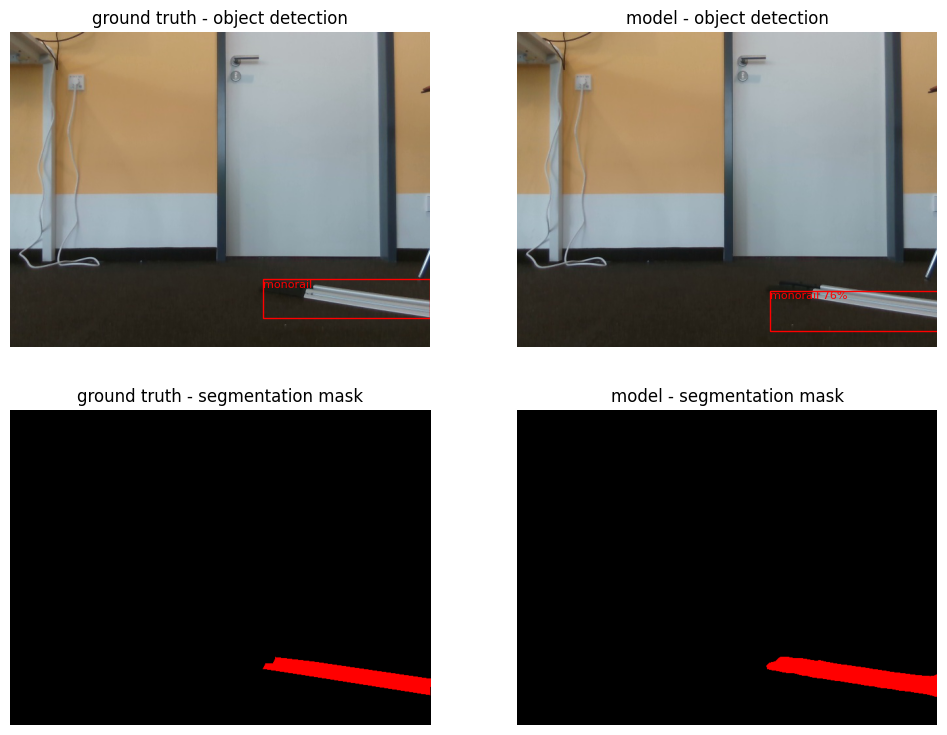

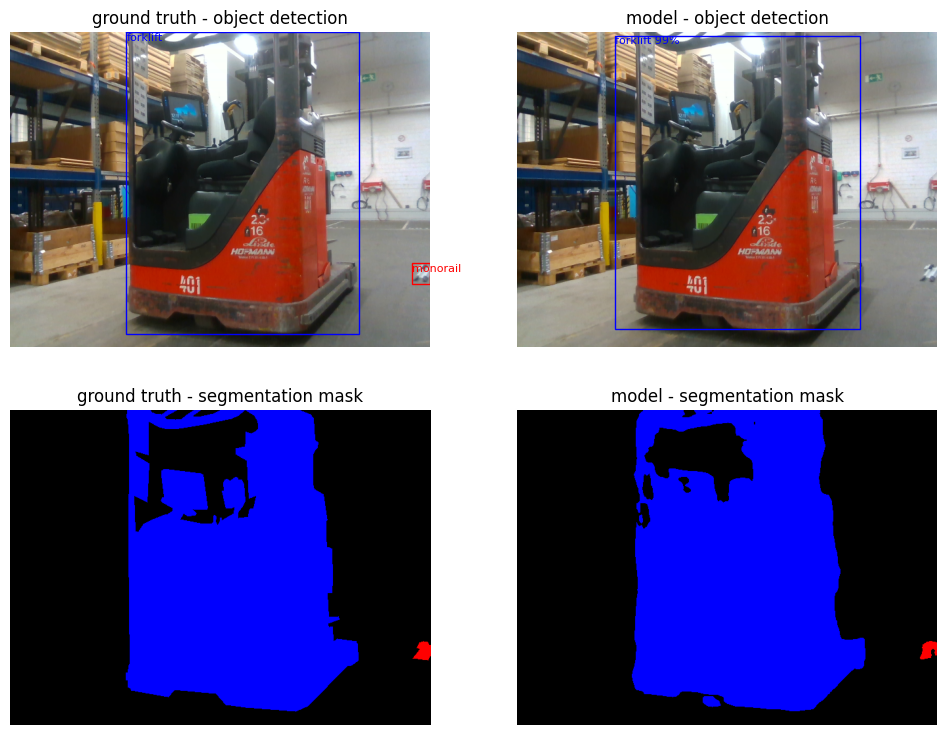

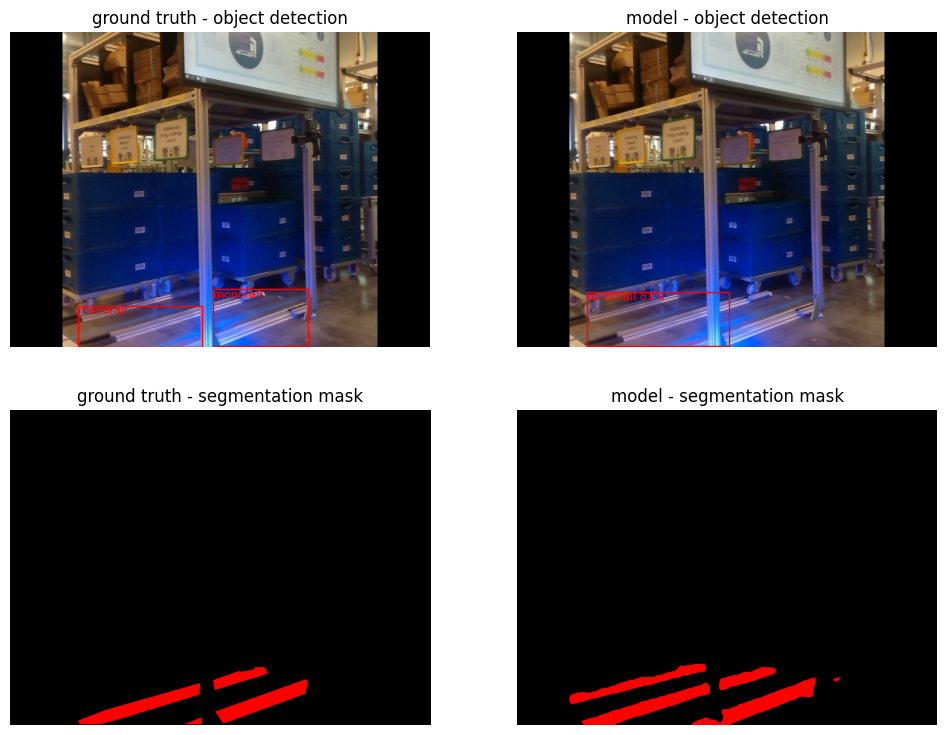

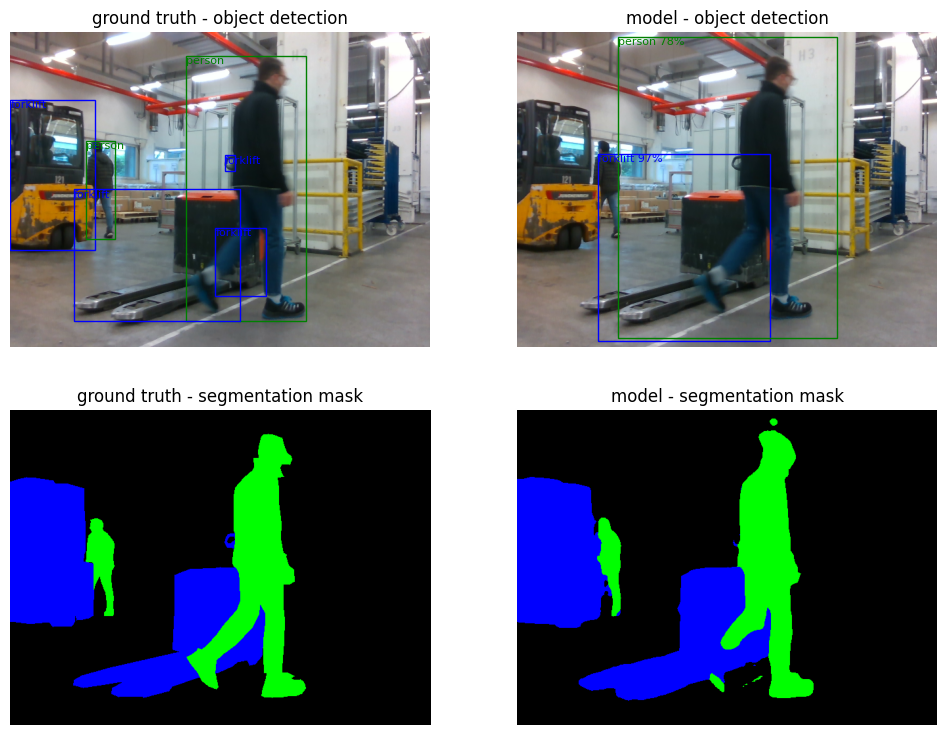

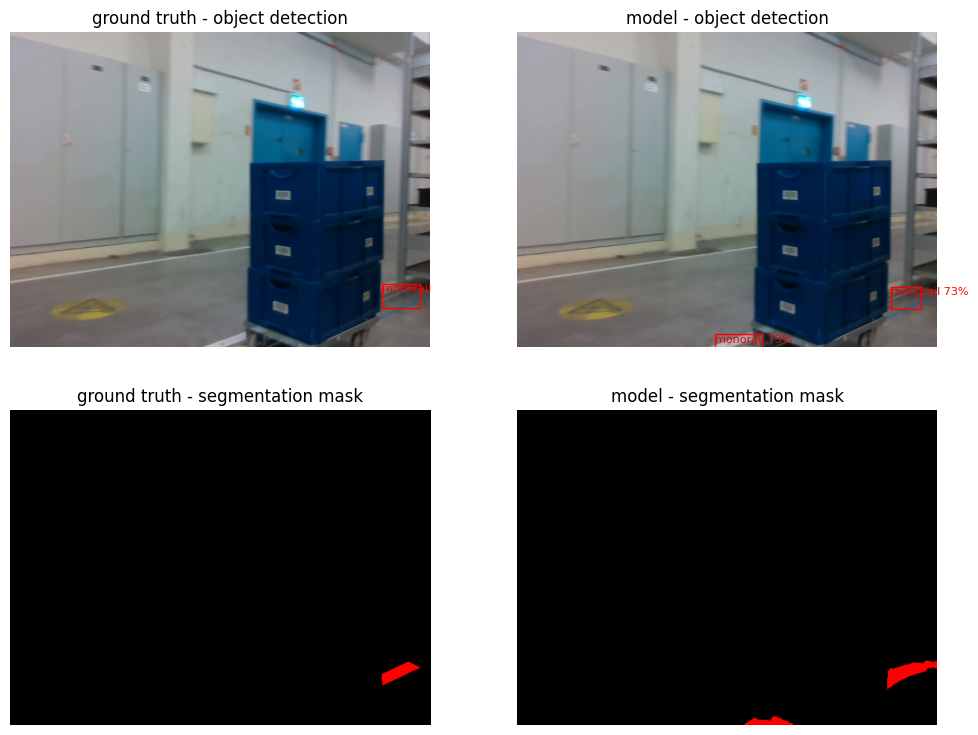

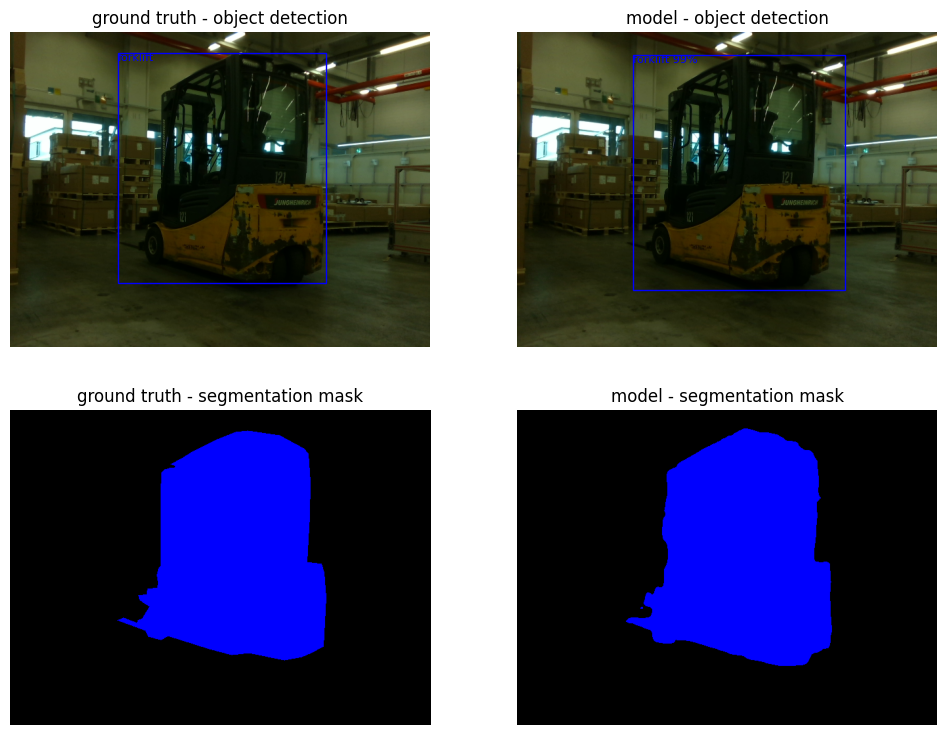

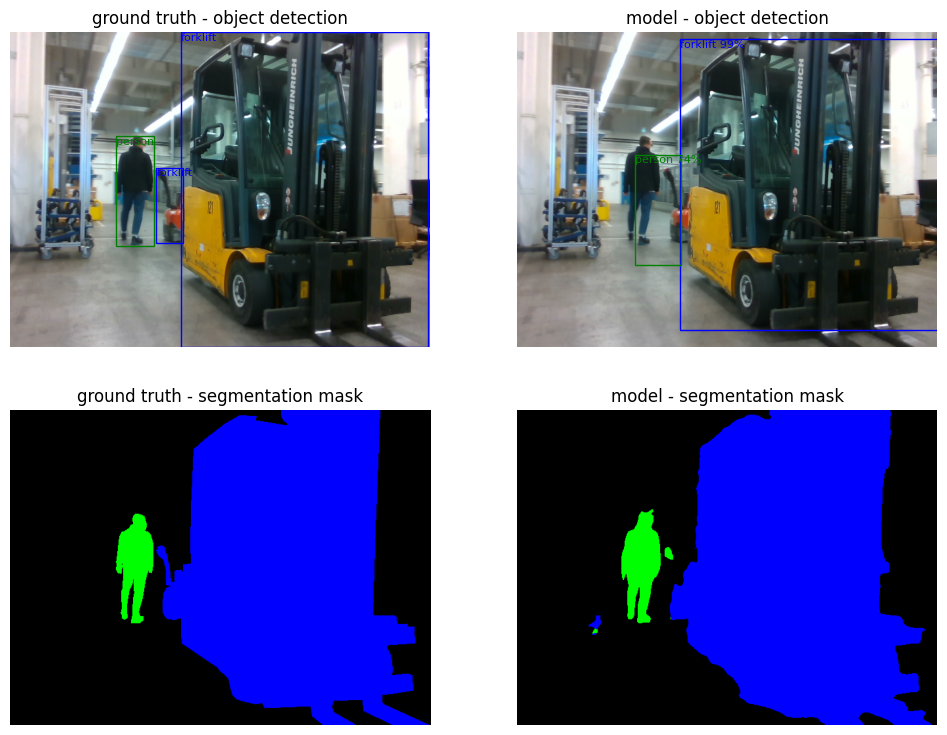

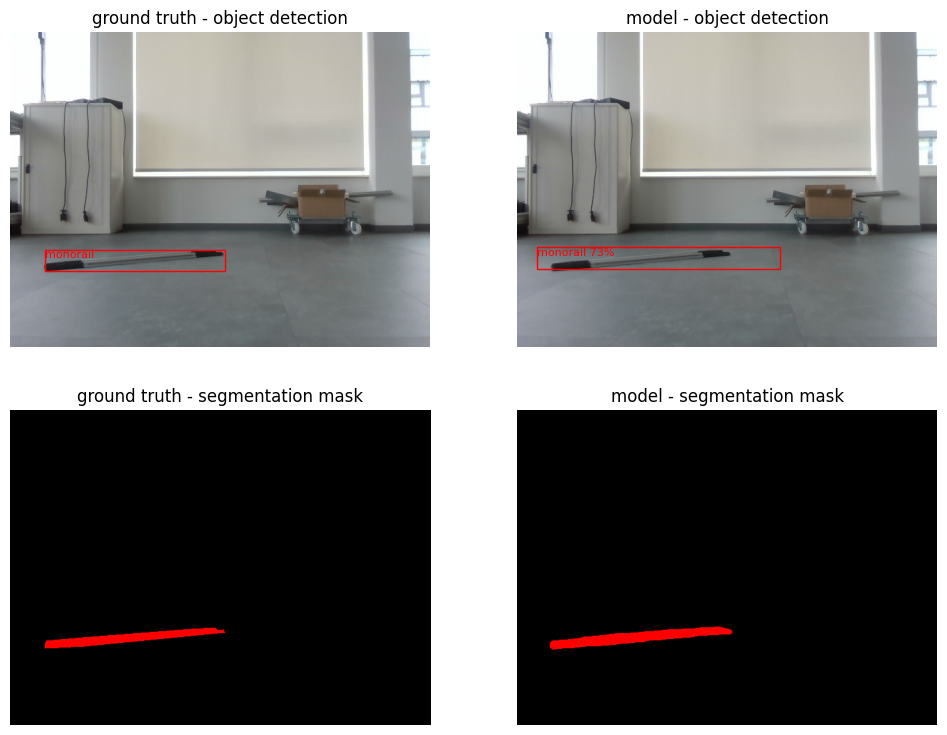

In [33]:
number_of_samples = 8
fig_size_width = 12
sample_indices = list(range(len(path_files_images_test)))

for i in random.sample(sample_indices, number_of_samples):
    
    # extract the sample
    path_file_image = path_files_images_test[i]
    path_file_mask = path_files_masks_test[i]
    path_file_labels_boxes = path_files_labels_boxes_test[i]

    # create the needed subplots and set figure size
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(fig_size_width, int(fig_size_width / (INPUT_IMAGE_SHAPE[1] / INPUT_IMAGE_SHAPE[0])))    

    # --------------------------------------------------------------------------------
    # read - image sample
    # --------------------------------------------------------------------------------
    # read image
    image = Image.open(path_file_image)

    # add batch dimension to image
    image_batch = np.array(image).astype(np.float32)
    image_batch = np.expand_dims(image, axis=0)

    # convert to array of integers
    image = np.array(image)
    image = image.astype(np.int32)

    # --------------------------------------------------------------------------------
    # read - segmentation mask sample
    # --------------------------------------------------------------------------------
    # read mask
    mask = Image.open(path_file_mask)

    # keep the 3 classes on rgb channels
    mask = tf.slice(tf.one_hot(mask, depth=4, dtype=tf.float32), begin=[0, 0, 1], size=[-1, -1, 3])

    # --------------------------------------------------------------------------------
    # read - labels boxes sample
    # --------------------------------------------------------------------------------    
    # read ground truth labels boxes from csv file
    with open(path_file_labels_boxes, 'r') as f:
        labels_boxes = list(csv.reader(f))
    
    # --------------------------------------------------------------------------------
    # plot - ground truth
    # --------------------------------------------------------------------------------
    # plot the image
    ax1.imshow(image, vmin=0, vmax=1)
    ax1.set_axis_off()
    ax1.set_title(f'ground truth - object detection')
    
    # plot ground truth boxes
    for label, xmin, ymin, xmax, ymax in labels_boxes:
        label = int(label)
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=LABEL_CODE_TO_COLOR[label], facecolor='none')
        ax1.add_patch(rect)
        ax1.text(xmin, ymin, LABEL_CODE_TO_DESC[label], fontsize=8, color=LABEL_CODE_TO_COLOR[label], verticalalignment='top')        

    # plot ground truth mask
    ax2.imshow(mask, vmin=0, vmax=1)
    ax2.set_axis_off()
    ax2.set_title('ground truth - segmentation mask')

    # --------------------------------------------------------------------------------
    # plot - model predictions
    # --------------------------------------------------------------------------------
    # get predictions from the model
    output_mask, output_object_detection = model_inference(image_batch, training=False)
    if output_object_detection.ndim > 2:
        output_object_detection = tf.squeeze(output_object_detection, axis=0)

    # keep the 3 classes on rgb channels
    output_mask = tf.math.argmax(tf.squeeze(output_mask, axis=0), axis=-1)
    output_mask = tf.one_hot(output_mask, depth=4, axis=2)
    output_mask = tf.slice(output_mask, begin=[0, 0, 1], size=[-1, -1, 3])

    # plot the image
    ax3.imshow(image, vmin=0, vmax=255)
    ax3.set_axis_off()
    ax3.set_title(f'model - object detection')

    # plot predicted boxes
    for label, probability, xmin, ymin, xmax, ymax in output_object_detection:
        if label == LABEL_CODE_BACKGROUND:
            continue
        label = int(label)
        probability = int(probability * 100)
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=LABEL_CODE_TO_COLOR[label], facecolor='none')
        ax3.add_patch(rect)
        ax3.text(xmin, ymin, f'{LABEL_CODE_TO_DESC[label]} {probability}%', fontsize=8, color=LABEL_CODE_TO_COLOR[label], verticalalignment='top')        

    # plot predicted mask
    ax4.imshow(output_mask, vmin=0, vmax=1)
    ax4.set_axis_off()
    ax4.set_title('model - segmentation mask')

    # show the plot
    plt.show()

## Conclusions

To sum it up, this project was a great learning experience. My goal was to develop a network capable of performing both object detection and semantic segmentation simultaneously, using SSDLite and DeepLabv3+. To keep it lightweight for potential real-time use on mobile devices, I chose MobileNetV2 and ShuffleNetV2 as the backbones.

Combining these tasks might seem strange, but it was challenging and fun to work on. I built everything from scratch using just NumPy and TensorFlow, resulting in a network with under 4M parameters that can perform both tasks simultaneously. Implementing each layer gave me a deeper understanding of how these techniques work, especially with SSD. Although it seemed complex at first, I was amazed by how straightforward and effective the approach is once I started coding it. The same is true for DeepLabV3+, which, while clearer from the start, was still fascinating to implement. Learning about the inner workings of MobileNetV2 and ShuffleNetV2, two well-known convolutional architectures for mobile applications, was also quite interesting.

The final results weren’t perfect, but given the small dataset and that the network was trained from scratch, I’m pleased with its performance. This project demonstrated how effective computer vision techniques can be, even with limited resources and data.

Overall, it was a challenging and rewarding experience. I learned a lot and am excited about the possibilities for future computer vision projects!